In [ ]:
pip install torchvision

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Используется устройство: cuda
Эпоха 1 [0/30596 (0%)]	Потеря: 549.2024
Эпоха 1 [12800/30596 (42%)]	Потеря: 174.9337
Эпоха 1 [25600/30596 (83%)]	Потеря: 148.4439
====> Эпоха 1 Средняя потеря: 184.6692
====> Тестовая потеря: 159.3100
Эпоха 2 [0/30596 (0%)]	Потеря: 142.7055
Эпоха 2 [12800/30596 (42%)]	Потеря: 133.6491
Эпоха 2 [25600/30596 (83%)]	Потеря: 123.6299
====> Эпоха 2 Средняя потеря: 130.1816
====> Тестовая потеря: 141.0483
Эпоха 3 [0/30596 (0%)]	Потеря: 126.0837
Эпоха 3 [12800/30596 (42%)]	Потеря: 117.8022
Эпоха 3 [25600/30596 (83%)]	Потеря: 114.9971
====> Эпоха 3 Средняя потеря: 118.0094
====> Тестовая потеря: 131.6825
Эпоха 4 [0/30596 (0%)]	Потеря: 109.6585
Эпоха 4 [12800/30596 (42%)]	Потеря: 109.2543
Эпоха 4 [25600/30596 (83%)]	Потеря: 108.7476
====> Эпоха 4 Средняя потеря: 112.3675
====> Тестовая потеря: 126.3574
Эпоха 5 [0/30596 (0%)]	Потеря: 116.2496
Эпоха 5 [12800/30596 (42%)]	Потеря: 109.7898
Эпоха 5 [25600/30596 (83%)]	Потеря: 111.4641
====> Эпоха 5 Средняя потеря: 109.35

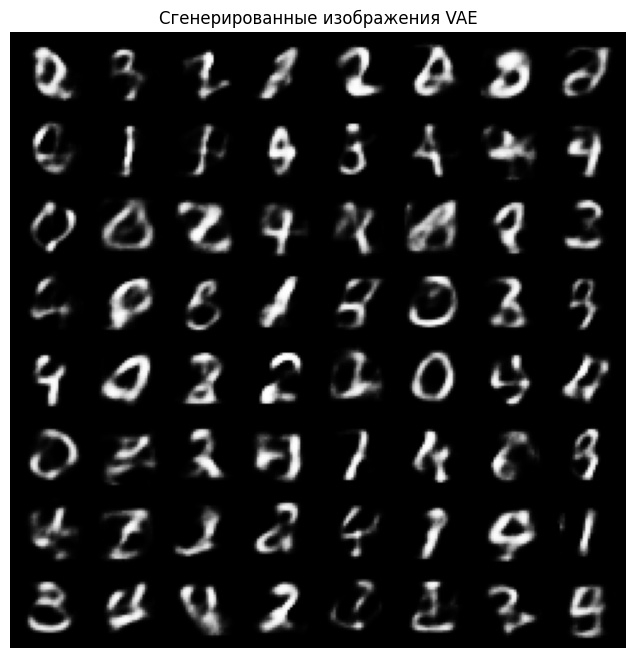

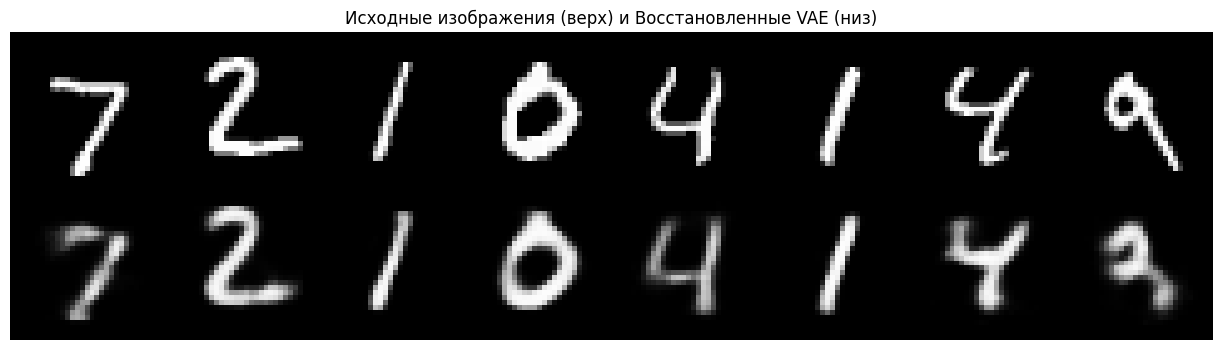

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Определение устройства (GPU если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

# Параметры модели
batch_size = 128
latent_dim = 20  # Размер латентного пространства
epochs = 10
learning_rate = 1e-3

# Функция для фильтрации данных
def filter_digits(dataset, digits):
    indices = np.isin(dataset.targets, digits)
    return Subset(dataset, np.where(indices)[0])

# Загрузка набора данных MNIST
transform = transforms.ToTensor()

# Обучающая выборка: цифры 0-4
train_dataset_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = filter_digits(train_dataset_full, digits=[0,1,2,3,4])

# Тестовая выборка: все цифры
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Определение архитектуры VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Энкодер
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)      # Среднее
        self.fc_logvar = nn.Linear(400, latent_dim)  # Логарифм дисперсии

        # Декодер
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # Стандартное отклонение
        eps = torch.randn_like(std)  # Случайная нормальная шумовая переменная
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Функция потерь для VAE
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')

    # Kullback-Leibler дивергенция
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# Инициализация модели и оптимизатора
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Функция обучения
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Эпоха {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tПотеря: {loss.item() / len(data):.4f}")

    print(f"====> Эпоха {epoch} Средняя потеря: {train_loss / len(train_loader.dataset):.4f}")

# Функция тестирования
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += loss_function(recon, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print(f"====> Тестовая потеря: {test_loss:.4f}")

# Обучение модели
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

# Генерация новых изображений
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample = model.decode(z).cpu()

    # Визуализация сгенерированных изображений
    grid_img = torchvision.utils.make_grid(sample.view(64, 1, 28, 28), nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title("Сгенерированные изображения VAE")
    plt.axis('off')
    plt.show()

# Восстановление изображений из тестового набора
def visualize_reconstructions():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = model(data)

        # Выбираем первые 8 изображений
        n = 8
        comparison = torch.cat([data[:n],
                                recon.view(batch_size, 1, 28, 28)[:n]])
        grid_img = torchvision.utils.make_grid(comparison, nrow=n)

        plt.figure(figsize=(16,4))
        plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        plt.title("Исходные изображения (верх) и Восстановленные VAE (низ)")
        plt.axis('off')
        plt.show()

visualize_reconstructions()


In [54]:
# Аномалии для датасета

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
